In [20]:
# Box prediction
# Trying again!
import time
from PIL import Image, ImageDraw
import numpy as np

import torch
import torch.nn as nn
from skimage import io
import math

from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import os

import seaborn as sns
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.transforms as mplTransforms
from datetime import datetime
plt.style.use('ggplot')


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("CUDA available? device: ", device)

# ---- Make depth images ------------------------------------
# -----------------------------------------------------------
IMG_X, IMG_Y = 100, 100
# length and width of blocks (fixed for now)
block_l, block_w = 10, 15 

batch_size = 25


# -- Calc rectangle vertices. credit Sparkler, stackoverflow, feb 17
def makeRectangle(l, w, theta, offset=(0, 0)):
    c, s = math.cos(theta), math.sin(theta)
    rectCoords = [(l / 2.0, w / 2.0), (l / 2.0, -w / 2.0),
                  (-l / 2.0, -w / 2.0), (-l / 2.0, w / 2.0)]
    return [(c * x - s * y + offset[0], s * x + c * y + offset[1]) for (x, y) in rectCoords]
    #return np.array([(c * x - s * y + offset[0], s * x + c * y + offset[1]) for (x, y) in rectCoords])


# ---- Save to file -------------------
def make_dataset(dirname, num_images):
    true_coords = []
    newpath = "./" + dirname
    if not os.path.exists(newpath):
        os.makedirs(newpath)
        print(newpath)
    for i in range(num_images):
        # orient = 0 # degrees
        img = Image.new("RGB", (IMG_X, IMG_Y), "black")

        # block_l and _w offset so blocks don't run off edge of image
        rand_x = int(np.random.rand() * (IMG_X - 2 * block_l)) + block_l
        rand_y = int(np.random.rand() * (IMG_Y - 2 * block_w)) + block_w
        orient = int(np.random.rand() * 180)  # .random() is range [0.0, 1.0).
        orient = math.radians(orient)  # math.cos takes radians!

        rect_vertices = makeRectangle(
            block_l, block_w, orient, offset=(rand_x, rand_y))

        # true_coords.append(np.array((rand_x, rand_y, math.degrees(orient))))
        #true_coords.append(np.array([rand_y, rand_x, np.cos(orient), np.sin(orient)]))
        true_coords.append(np.array(rect_vertices).flatten())
        
        idraw = ImageDraw.Draw(img)
        idraw.polygon(rect_vertices, fill="white")

        img.save(newpath + "/rect" + str(i) + ".png")
    return true_coords


# ---- Define dataloader ------------------------------------
# -----------------------------------------------------------
class RectDepthImgsDataset(Dataset):
    """Artificially generated depth images dataset"""

    def __init__(self, img_dir, coords, transform=None):
        self.img_dir = img_dir
        self.true_coords = coords
        self.transform = transform

    def __len__(self):
        # print('true coord len', len(self.true_coords))
        return len(self.true_coords)

    def __getitem__(self, idx):
        # image = self.images[idx]
        image = io.imread(self.img_dir + '/rect' + str(idx) + '.png')
        image = torch.FloatTensor(image).permute(
            2, 0, 1)  # PIL and torch expect difft orders
        coords = torch.FloatTensor(self.true_coords[idx])

        if self.transform:
            image = self.transform(image)

        # sample = {'image': image, 'grasp': str(coords[0]) + str(coords[1])}
        sample = {'image': image, 'grasp': coords}
        sample = image, coords

        return sample


# ---- Define Net ------------------------------------
# ----------------------------------------------------
class Net(nn.Module):  # CIFAR is 32x32x3, MNIST is 28x28pred_x)
    def __init__(self, IMG_X, IMG_Y):
        super(Net, self).__init__()

        self._imgx = IMG_X
        self._imgy = IMG_Y
        _pool = 2
        _stride = 5
        _outputlayers = 16

        num_classes = 8

        def _calc(val):
            layer_size = (val - (_stride - 1)) / _pool
            return layer_size

            # print(self._imgx)
        self._const = _calc(_calc(self._imgx))
        self._const *= _calc(_calc(self._imgy))
        self._const *= _outputlayers 
        # print(self._const)
        self._const = int(self._const)

        self.conv1 = nn.Conv2d(3, 100, _stride).to(device)
        self.pool = nn.MaxPool2d(_pool, _pool).to(device)
        self.conv2 = nn.Conv2d(100, _outputlayers, _stride).to(device)
        self.fc1 = nn.Linear(self._const, 120).to(device)
        self.fc2 = nn.Linear(120, 84).to(device)
        self.fc3 = nn.Linear(84, num_classes).to(device)

    def forward(self, x):
        # print(x.size())
        x = x.to(device)
        x = x.view(-1, 3, IMG_X, IMG_Y)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, self._const)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# -- Utility fxn -------------------------------------
# Source: https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection/blob/master/train.py
# ---------------------------------------------------


class AverageMeter(object):
    """
    Keeps track of most recent, average, sum, and count of a metric.
    """

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def save_checkpoint(epoch, epochs_since_improvement, regrModel,
                    loss_history,
                    regrLoss, best_loss, is_best):
    # Save checkpoint
    """
    Save model checkpoint.
    :param epoch: epoch number
    :param epochs_since_improvement: number of epochs since last improvement
    :param model: model
    :param optimizer: optimizer
    :param loss: validation loss in this epoch
    :param best_loss: best validation loss achieved so far (not necessarily in this checkpoint)
    :param is_best: is this checkpoint the best so far?
    """
    state = {
        "epoch": epoch,
        "epochs_since_improvement": epochs_since_improvement,
        "regrModel": regrModel,
        "regrLoss": regrLoss,
        "loss_history": loss_history,
        "best_loss": best_loss,
        "is_best": is_best
    }

    filename = "checkpoint_attempt2.tar"
    torch.save(state, filename)
    # If this checkpoint is the best so far, store a copy so it doesn't get overwritten by a worse checkpoint
    if is_best:
        torch.save(state, "BEST_" + filename)

# -- Main Functions --------------------------------------------------
# --------------------------------------------------------------------


def run_dataset_creation():
    train_truth = make_dataset('data', 5000)
    print(len(train_truth))
    test_truth = make_dataset('./data/test', 300)
    # to things

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("CUDA available? device: ", device)

    # Dataset is depth images of rectangular blocks
    global train_loader
    train_dataset = RectDepthImgsDataset(img_dir='./data', coords=train_truth)
    # Data loader
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size,
                              shuffle=True)

    test_dataset = RectDepthImgsDataset(
        img_dir='./data/test', coords=test_truth)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size,
                             shuffle=True)

    np.save("train_truth.npy", train_truth)
    np.save("test_truth.npy", test_truth)


def train_dataset():

    num_classes = 3  # predicting x,y,orientation
    learning_rate = 0.0001
    criterion = nn.MSELoss()
    num_epochs = 100 

    print_freq = 25  # print training or validation status every __ batches
    epochs_since_improvement = 0
    best_loss = 5000.0  # assume a high loss at first

    train_truth = np.load("train_truth.npy")
    # loading the training and testing data5
    test_truth = np.load("test_truth.npy")

    batch_time = AverageMeter()  # forward prop. + back prop. time
    data_time = AverageMeter()  # data loading time
    loss_avg = AverageMeter()  # loss
    loss_history = []

    # -- Instantiate CNN -------------------------
    regrModel = Net(IMG_X, IMG_Y)
    regrModel = regrModel.to(device)
    optimizer = torch.optim.Adam(regrModel.parameters(), lr=learning_rate)

    regrModel.train()  # enable dropout
    print('Training model now...')

    # -- Load datasets -------------------------
    train_truth = np.load("train_truth.npy")
    train_dataset = RectDepthImgsDataset(img_dir='./data', coords=train_truth)
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size,
                              shuffle=True)

    # -- Begin training -------------------------
    print('Start time: ',  datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    start = time.time()

    for epoch in range(num_epochs):

        for i_batch, (images, labels) in enumerate(train_loader):
            data_time.update(time.time() - start)

            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = regrModel(images).to(device)

            regrLoss = criterion(outputs, labels)
            loss_history.append(regrLoss)

            optimizer.zero_grad()
            regrLoss.backward()

            # Update Model
            optimizer.step()

            loss_avg.update(regrLoss.item())

            # Print status
            batch_time.update(time.time() - start)
            start = time.time()

            if i_batch % print_freq == 0:
                print(
                    "Epoch: [{0}][{1}/{2}]\t"
                    "Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t"
                    "Loss {loss.val:.4f} (Avg {loss.avg:.4f})\t".format(
                        epoch,
                        i_batch,
                        len(train_loader),
                        batch_time=batch_time,
                        loss=loss_avg,
                    )
                )

        # One epoch's loss
        is_best = loss_avg.avg < best_loss
        best_loss = min(loss_avg.avg, best_loss)

        if not is_best:
            epochs_since_improvement += 1
            print("\nEpochs since last improvement: %d, %d loss\n" %
                  (epochs_since_improvement, loss_avg.avg))

        else:
            epochs_since_improvement = 0

        # Save checkpoint
        save_checkpoint(epoch, epochs_since_improvement, regrModel,
                        loss_history,
                        loss_avg.avg, best_loss, is_best)
    print('End time: ',  datetime.now().strftime('%Y-%m-%d %H:%M:%S'))


# --- VIEW RESULTS ----------------------------------------
# ---------------------------------------------------------

def view_loss_results():
    filename = "checkpoint_attempt2.tar"
    checkpoint = torch.load(filename)
    start_epoch = checkpoint['epoch'] + 1
    best_loss = checkpoint['best_loss']
    loss_history = checkpoint['loss_history']
    regrModel = checkpoint['regrModel']

    print('\nLoaded checkpoint from epoch %d. Best loss so far is %.3f.\n' %
          (start_epoch, best_loss))
    test_truth = np.load("test_truth.npy")
    test_dataset = RectDepthImgsDataset(
        img_dir='./data/test', coords=test_truth)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size,
                             shuffle=True)

    criterion = nn.MSELoss()

    with torch.no_grad():

        dataiter = iter(test_loader)
        images, labels = dataiter.next()

        # Move to default device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = regrModel(images)
        loss = criterion(outputs, labels)

        # Loss
        print("loss across batch size of ", labels.size()[0], 'is: \n', loss)

        # print(labels)
        print('\n!-- labels size', labels.size())

        plt.plot(range(len(loss_history)), loss_history)  # regr loss
        plt.show()
        
        plt.plot(range(len(loss_history)), loss_history)  # regr loss
        
        plt.xlim((4500, 5100))
        plt.ylim((0,30))
        
        plt.show()

        # sns.regplot(x=np.arange(len(loss_history)),
        # y=np.array(loss_history)) # regr loss


def view_image_results():
    filename = "checkpoint_attempt2.tar"
    checkpoint = torch.load(filename)
    start_epoch = checkpoint['epoch'] + 1
    best_loss = checkpoint['best_loss']
    loss_history = checkpoint['loss_history']
    regrModel = checkpoint['regrModel']

    print('\nLoaded checkpoint from epoch %d. Best loss so far is %.3f.\n' %
          (start_epoch, best_loss))

    test_truth = np.load("test_truth.npy")
    test_dataset = RectDepthImgsDataset(
        img_dir='./data/test', coords=test_truth)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size,
                             shuffle=True)

    criterion = nn.MSELoss()

    with torch.no_grad():

        dataiter = iter(test_loader)
        images, coords = dataiter.next()

        # Move to default device
        images = images.to(device)
        coords = coords.to(device)

        # Forward pass
        outputs = regrModel(images)

        labels = coords.cpu()

        plt.rcParams['figure.figsize'] = [50, 10]

        fig, ax = plt.subplots()

        print('lenlabels', len(labels))
        print(block_l, block_w, IMG_X, IMG_Y)

        for i in range(len(labels) - 10):
            #print('i', i)
            #cornerUR, cornerLR, cornerLL, cornerUL = labels[i].numpy()
            corners = labels[i].numpy()
            pred_corners = outputs[i].cpu().numpy()
            print('i', i, 'truth: ', corners, 'pred:', pred_corners) 
            
            unflattened_corners = []
            pred_unflattened_corners = []
            for j in range(4):
                tmpx = corners[2 * j] + (i * IMG_X)
                tmpy = corners[(2 * j) + 1]
                pred_tmpx = pred_corners[2 * j] + (i * IMG_X)
                pred_tmpy = pred_corners[(2 * j) + 1]
                unflattened_corners.append((tmpx, tmpy))
                pred_unflattened_corners.append((pred_tmpx, pred_tmpy))
            unflattened_corners = np.array(unflattened_corners)
            pred_unflattened_corners = np.array(pred_unflattened_corners)
                

                
            # -- Plot truth rectangle 
            truth_rect = patches.Polygon(unflattened_corners, closed=True, fill=True, color='black')
            # correct for rotation around LL corner
            ax.add_patch(truth_rect)
            

            # -- Plot prediction
            pred_rect = patches.Polygon(pred_unflattened_corners, closed=True, fill=True, color='orange')
            # correct for rotation around LL corner
            ax.add_patch(pred_rect)
            
            # -- Plot image border 
            image_outline = patches.Rectangle((i * IMG_X, 0), 200, 200, angle=0, fill=False, color='black')
            ax.add_patch(image_outline)

            # Scatter plot of true centers
            # TODO: add logic to offset back to center correctly (accounting for theta)
            x, y = corners[0], corners[1]
            x, y = x - (block_l/2.0), y - (block_w/2.0)
            ax.scatter(x + i * IMG_X, y, color='r', marker='x', linewidth='1',
                       zorder=100)
        ax.set_aspect('equal', 'box')
        plt.show()


def main():
    print('Creating dataset')
    run_dataset_creation()

    print('Training model')
    train_dataset()

    print('View results')

    view_loss_results()
    view_image_results()

    #input('Close all?')
    #plt.close('all')


#if __name__ == '__main__':
    #main()

CUDA available? device:  cuda:0


Creating dataset
5000
CUDA available? device:  cuda:0
Training model
Training model now...
Start time:  2019-04-03 21:21:41
Epoch: [0][0/200]	Batch Time 0.026 (0.026)	Loss 3007.9133 (Avg 3007.9133)	
Epoch: [0][25/200]	Batch Time 0.022 (0.024)	Loss 318.9456 (Avg 1544.7164)	
Epoch: [0][50/200]	Batch Time 0.022 (0.023)	Loss 57.4598 (Avg 841.9921)	
Epoch: [0][75/200]	Batch Time 0.021 (0.023)	Loss 50.3911 (Avg 581.8066)	
Epoch: [0][100/200]	Batch Time 0.022 (0.022)	Loss 33.3442 (Avg 447.4205)	
Epoch: [0][125/200]	Batch Time 0.022 (0.022)	Loss 49.1808 (Avg 366.4827)	
Epoch: [0][150/200]	Batch Time 0.022 (0.022)	Loss 36.6527 (Avg 311.9424)	
Epoch: [0][175/200]	Batch Time 0.021 (0.022)	Loss 30.9128 (Avg 272.8653)	


/home/rui/mlenv/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: [1][0/200]	Batch Time 0.045 (0.022)	Loss 43.0311 (Avg 243.4258)	
Epoch: [1][25/200]	Batch Time 0.021 (0.022)	Loss 30.3767 (Avg 220.2106)	
Epoch: [1][50/200]	Batch Time 0.022 (0.022)	Loss 30.9278 (Avg 201.7606)	
Epoch: [1][75/200]	Batch Time 0.022 (0.022)	Loss 35.9467 (Avg 186.7189)	
Epoch: [1][100/200]	Batch Time 0.022 (0.022)	Loss 29.0676 (Avg 173.9904)	
Epoch: [1][125/200]	Batch Time 0.022 (0.022)	Loss 31.9254 (Avg 163.2173)	
Epoch: [1][150/200]	Batch Time 0.022 (0.022)	Loss 25.8454 (Avg 153.8688)	
Epoch: [1][175/200]	Batch Time 0.021 (0.022)	Loss 35.4608 (Avg 145.8826)	
Epoch: [2][0/200]	Batch Time 0.051 (0.022)	Loss 26.7078 (Avg 138.8020)	
Epoch: [2][25/200]	Batch Time 0.021 (0.022)	Loss 32.6090 (Avg 132.4681)	
Epoch: [2][50/200]	Batch Time 0.021 (0.022)	Loss 24.9314 (Avg 126.7496)	
Epoch: [2][75/200]	Batch Time 0.021 (0.022)	Loss 38.4618 (Avg 121.6744)	
Epoch: [2][100/200]	Batch Time 0.021 (0.022)	Loss 30.9685 (Avg 117.1345)	
Epoch: [2][125/200]	Batch Time 0.021 (0.022)	Los

Epoch: [15][50/200]	Batch Time 0.022 (0.022)	Loss 2.1358 (Avg 27.7970)	
Epoch: [15][75/200]	Batch Time 0.022 (0.022)	Loss 2.2586 (Avg 27.5972)	
Epoch: [15][100/200]	Batch Time 0.022 (0.022)	Loss 3.0714 (Avg 27.3981)	
Epoch: [15][125/200]	Batch Time 0.021 (0.022)	Loss 2.6288 (Avg 27.2028)	
Epoch: [15][150/200]	Batch Time 0.021 (0.022)	Loss 3.5725 (Avg 27.0173)	
Epoch: [15][175/200]	Batch Time 0.021 (0.022)	Loss 3.7931 (Avg 26.8320)	
Epoch: [16][0/200]	Batch Time 0.168 (0.022)	Loss 2.9368 (Avg 26.6493)	
Epoch: [16][25/200]	Batch Time 0.021 (0.022)	Loss 2.6089 (Avg 26.4638)	
Epoch: [16][50/200]	Batch Time 0.022 (0.022)	Loss 1.9822 (Avg 26.2810)	
Epoch: [16][75/200]	Batch Time 0.021 (0.022)	Loss 3.1002 (Avg 26.1014)	
Epoch: [16][100/200]	Batch Time 0.023 (0.022)	Loss 3.0439 (Avg 25.9246)	
Epoch: [16][125/200]	Batch Time 0.022 (0.022)	Loss 2.5835 (Avg 25.7544)	
Epoch: [16][150/200]	Batch Time 0.023 (0.022)	Loss 4.3991 (Avg 25.5881)	
Epoch: [16][175/200]	Batch Time 0.022 (0.022)	Loss 4.1969 

Epoch: [29][100/200]	Batch Time 0.021 (0.022)	Loss 1.3812 (Avg 15.4403)	
Epoch: [29][125/200]	Batch Time 0.021 (0.022)	Loss 1.3828 (Avg 15.3808)	
Epoch: [29][150/200]	Batch Time 0.021 (0.022)	Loss 1.2261 (Avg 15.3215)	
Epoch: [29][175/200]	Batch Time 0.021 (0.022)	Loss 1.5527 (Avg 15.2629)	
Epoch: [30][0/200]	Batch Time 0.282 (0.022)	Loss 0.9615 (Avg 15.2048)	
Epoch: [30][25/200]	Batch Time 0.021 (0.022)	Loss 2.0546 (Avg 15.1473)	
Epoch: [30][50/200]	Batch Time 0.021 (0.022)	Loss 0.9484 (Avg 15.0894)	
Epoch: [30][75/200]	Batch Time 0.022 (0.022)	Loss 1.5429 (Avg 15.0323)	
Epoch: [30][100/200]	Batch Time 0.021 (0.022)	Loss 1.4676 (Avg 14.9765)	
Epoch: [30][125/200]	Batch Time 0.021 (0.022)	Loss 1.1059 (Avg 14.9204)	
Epoch: [30][150/200]	Batch Time 0.022 (0.022)	Loss 2.0322 (Avg 14.8648)	
Epoch: [30][175/200]	Batch Time 0.021 (0.022)	Loss 2.4427 (Avg 14.8121)	
Epoch: [31][0/200]	Batch Time 0.293 (0.022)	Loss 1.4774 (Avg 14.7590)	
Epoch: [31][25/200]	Batch Time 0.021 (0.022)	Loss 1.4678 (

Epoch: [43][150/200]	Batch Time 0.021 (0.023)	Loss 1.0552 (Avg 10.7758)	
Epoch: [43][175/200]	Batch Time 0.020 (0.023)	Loss 0.9744 (Avg 10.7482)	
Epoch: [44][0/200]	Batch Time 0.405 (0.023)	Loss 1.3796 (Avg 10.7209)	
Epoch: [44][25/200]	Batch Time 0.022 (0.023)	Loss 1.9028 (Avg 10.6952)	
Epoch: [44][50/200]	Batch Time 0.021 (0.023)	Loss 0.6702 (Avg 10.6679)	
Epoch: [44][75/200]	Batch Time 0.023 (0.023)	Loss 1.1611 (Avg 10.6402)	
Epoch: [44][100/200]	Batch Time 0.022 (0.023)	Loss 1.4291 (Avg 10.6138)	
Epoch: [44][125/200]	Batch Time 0.021 (0.023)	Loss 0.8476 (Avg 10.5871)	
Epoch: [44][150/200]	Batch Time 0.022 (0.023)	Loss 2.4822 (Avg 10.5633)	
Epoch: [44][175/200]	Batch Time 0.025 (0.023)	Loss 1.4756 (Avg 10.5398)	
Epoch: [45][0/200]	Batch Time 0.439 (0.023)	Loss 1.1018 (Avg 10.5145)	
Epoch: [45][25/200]	Batch Time 0.023 (0.023)	Loss 0.5509 (Avg 10.4875)	
Epoch: [45][50/200]	Batch Time 0.021 (0.023)	Loss 0.6939 (Avg 10.4608)	
Epoch: [45][75/200]	Batch Time 0.021 (0.023)	Loss 0.6110 (Av

Epoch: [58][25/200]	Batch Time 0.022 (0.023)	Loss 0.3700 (Avg 8.3201)	
Epoch: [58][50/200]	Batch Time 0.021 (0.023)	Loss 0.9735 (Avg 8.3032)	
Epoch: [58][75/200]	Batch Time 0.022 (0.023)	Loss 0.5291 (Avg 8.2863)	
Epoch: [58][100/200]	Batch Time 0.021 (0.023)	Loss 1.3837 (Avg 8.2704)	
Epoch: [58][125/200]	Batch Time 0.022 (0.023)	Loss 0.5028 (Avg 8.2541)	
Epoch: [58][150/200]	Batch Time 0.021 (0.023)	Loss 0.5672 (Avg 8.2376)	
Epoch: [58][175/200]	Batch Time 0.022 (0.023)	Loss 0.5986 (Avg 8.2215)	
Epoch: [59][0/200]	Batch Time 0.573 (0.023)	Loss 0.5808 (Avg 8.2064)	
Epoch: [59][25/200]	Batch Time 0.022 (0.023)	Loss 0.7309 (Avg 8.1906)	
Epoch: [59][50/200]	Batch Time 0.022 (0.023)	Loss 0.4165 (Avg 8.1744)	
Epoch: [59][75/200]	Batch Time 0.021 (0.023)	Loss 0.5939 (Avg 8.1582)	
Epoch: [59][100/200]	Batch Time 0.021 (0.023)	Loss 0.3194 (Avg 8.1420)	
Epoch: [59][125/200]	Batch Time 0.021 (0.023)	Loss 0.3655 (Avg 8.1258)	
Epoch: [59][150/200]	Batch Time 0.021 (0.023)	Loss 0.4231 (Avg 8.1097)	


Epoch: [72][100/200]	Batch Time 0.021 (0.023)	Loss 0.1822 (Avg 6.7820)	
Epoch: [72][125/200]	Batch Time 0.022 (0.023)	Loss 0.2229 (Avg 6.7708)	
Epoch: [72][150/200]	Batch Time 0.022 (0.023)	Loss 0.5489 (Avg 6.7597)	
Epoch: [72][175/200]	Batch Time 0.022 (0.023)	Loss 0.5585 (Avg 6.7491)	
Epoch: [73][0/200]	Batch Time 0.727 (0.023)	Loss 0.9091 (Avg 6.7385)	
Epoch: [73][25/200]	Batch Time 0.022 (0.023)	Loss 0.4802 (Avg 6.7286)	
Epoch: [73][50/200]	Batch Time 0.022 (0.023)	Loss 0.5311 (Avg 6.7187)	
Epoch: [73][75/200]	Batch Time 0.023 (0.023)	Loss 0.5688 (Avg 6.7086)	
Epoch: [73][100/200]	Batch Time 0.022 (0.023)	Loss 0.4161 (Avg 6.6981)	
Epoch: [73][125/200]	Batch Time 0.023 (0.023)	Loss 0.5230 (Avg 6.6874)	
Epoch: [73][150/200]	Batch Time 0.022 (0.023)	Loss 0.4877 (Avg 6.6766)	
Epoch: [73][175/200]	Batch Time 0.021 (0.023)	Loss 0.2840 (Avg 6.6659)	
Epoch: [74][0/200]	Batch Time 0.695 (0.023)	Loss 0.4105 (Avg 6.6553)	
Epoch: [74][25/200]	Batch Time 0.021 (0.023)	Loss 1.0612 (Avg 6.6450)	


Epoch: [86][175/200]	Batch Time 0.023 (0.024)	Loss 0.3384 (Avg 5.7367)	
Epoch: [87][0/200]	Batch Time 0.820 (0.024)	Loss 0.3992 (Avg 5.7291)	
Epoch: [87][25/200]	Batch Time 0.022 (0.024)	Loss 0.3701 (Avg 5.7214)	
Epoch: [87][50/200]	Batch Time 0.023 (0.024)	Loss 0.1729 (Avg 5.7137)	
Epoch: [87][75/200]	Batch Time 0.023 (0.024)	Loss 0.2020 (Avg 5.7060)	
Epoch: [87][100/200]	Batch Time 0.023 (0.024)	Loss 0.2565 (Avg 5.6982)	
Epoch: [87][125/200]	Batch Time 0.022 (0.024)	Loss 0.2564 (Avg 5.6905)	
Epoch: [87][150/200]	Batch Time 0.024 (0.024)	Loss 0.2229 (Avg 5.6828)	
Epoch: [87][175/200]	Batch Time 0.023 (0.024)	Loss 0.2455 (Avg 5.6751)	
Epoch: [88][0/200]	Batch Time 0.828 (0.024)	Loss 0.2500 (Avg 5.6673)	
Epoch: [88][25/200]	Batch Time 0.022 (0.024)	Loss 0.2605 (Avg 5.6597)	
Epoch: [88][50/200]	Batch Time 0.023 (0.024)	Loss 0.2795 (Avg 5.6520)	
Epoch: [88][75/200]	Batch Time 0.022 (0.024)	Loss 0.2747 (Avg 5.6443)	
Epoch: [88][100/200]	Batch Time 0.022 (0.024)	Loss 0.2143 (Avg 5.6368)	
Ep

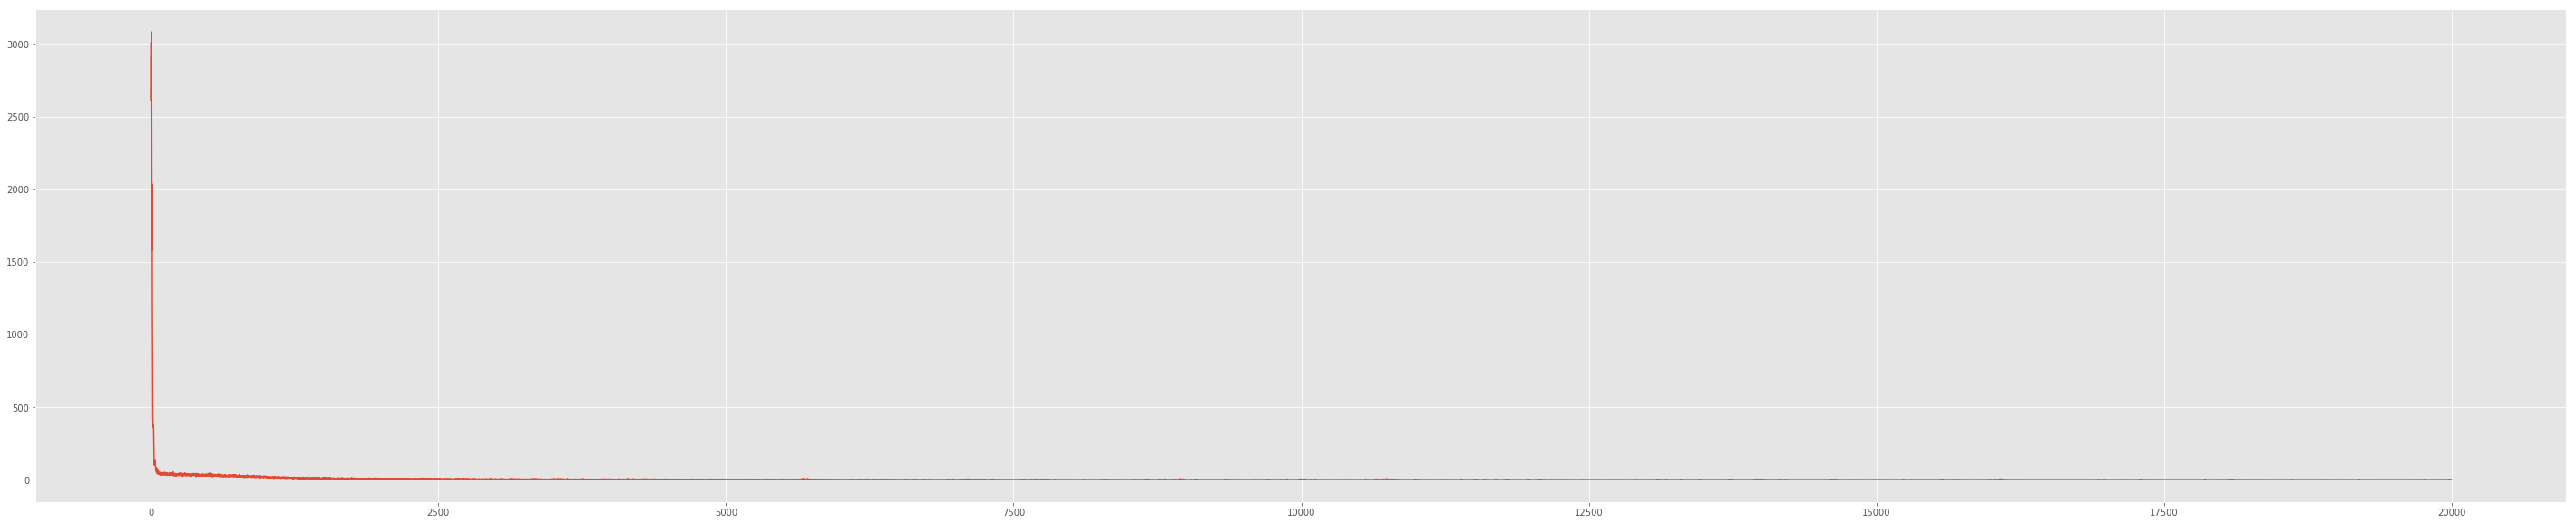

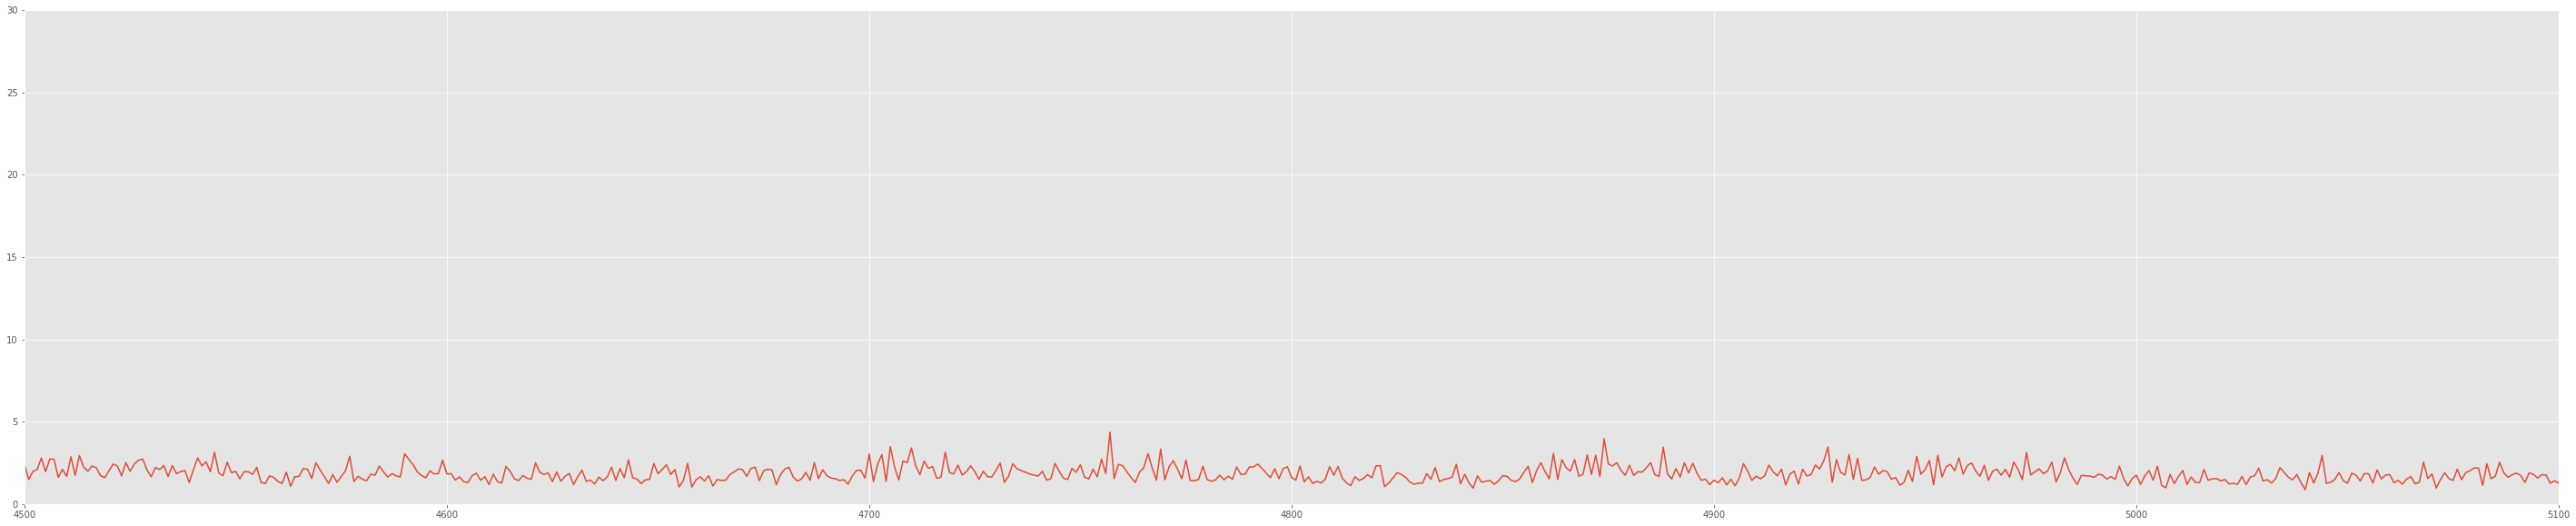


Loaded checkpoint from epoch 100. Best loss so far is 5.035.

lenlabels 25
10 15 100 100
i 0 truth:  [67.37451  84.1117   82.189835 81.76518  80.62549  71.8883   65.810165
 74.23482 ] pred: [67.23982  82.004326 80.70863  83.7633   81.2217   75.707504 69.18654
 73.14503 ]
i 1 truth:  [79.19337  58.078243 89.613235 68.86834  96.80663  61.921757 86.386765
 51.13166 ] pred: [75.985306 57.763725 87.926216 67.40152  93.89193  59.434856 82.067245
 49.748768]
i 2 truth:  [49.736385 62.662407 54.866688 76.7578   64.26361  73.33759  59.133312
 59.242203] pred: [49.788113 63.96852  56.44454  79.0683   66.49691  73.76839  58.900772
 59.098324]
i 3 truth:  [17.00481  82.080124 29.99519  74.580124 24.99519  65.919876 12.004809
 73.419876] pred: [17.266209 80.51154  28.491198 73.13019  23.203787 65.66048  12.058848
 73.584946]
i 4 truth:  [55.064224 28.72525  62.1063   41.969463 70.935776 37.27475  63.8937
 24.030535] pred: [55.245613 26.799528 59.66509  41.61298  70.29574  38.275043 63.795494
 23.6

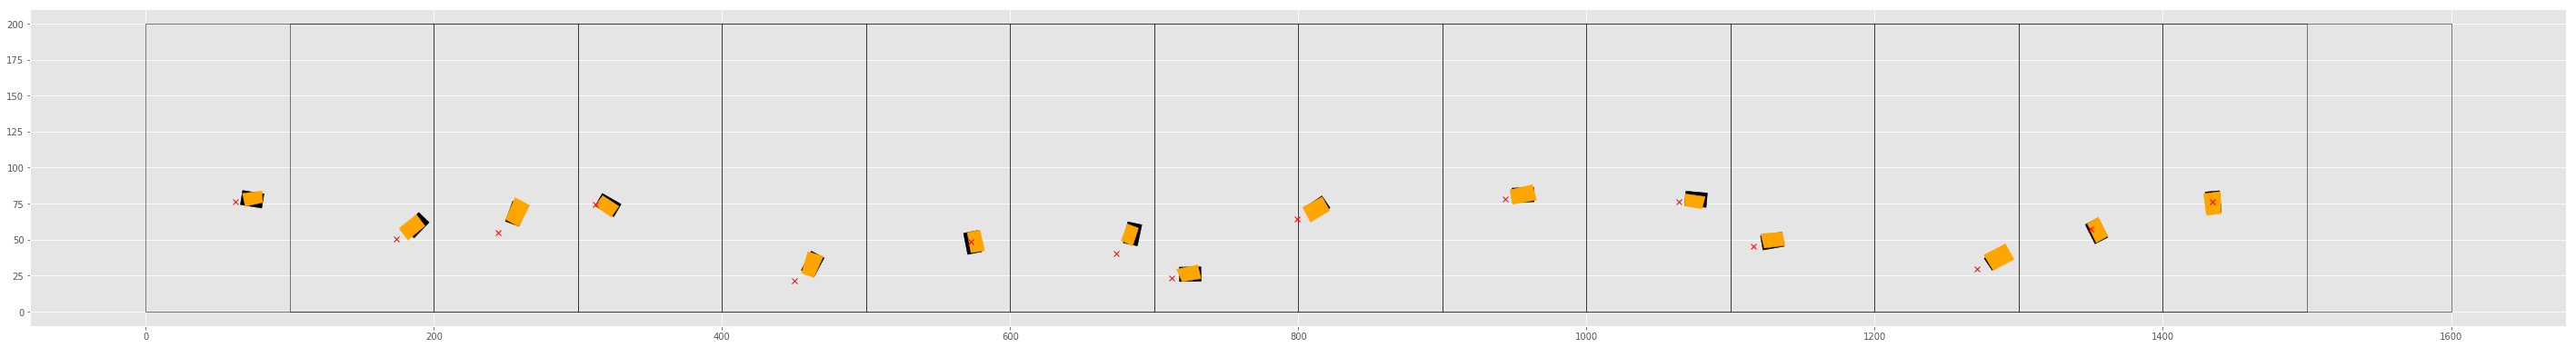

In [21]:
main()

In [ ]:
# -- Calc rectangle vertices. credit Sparkler, stackoverflow, feb 17
def makeRectangle(l, w, theta, offset=(0, 0)):
    c, s = math.cos(theta), math.sin(theta)
    rectCoords = [(l / 2.0, w / 2.0), (l / 2.0, -w / 2.0),
                  (-l / 2.0, -w / 2.0), (-l / 2.0, w / 2.0)]
    #return np.array([(c * x - s * y + offset[0], s * x + c * y + offset[1]) for (x, y) in rectCoords]).flatten()
    return [(c * x - s * y + offset[0], s * x + c * y + offset[1]) for (x, y) in rectCoords]

verts = makeRectangle(20,30,0)
print('verts', verts)
verts = np.array(verts).flatten()
unflat = []
for i in range(4):
    print(i)
    tmpx = verts[2 * i]
    tmpy = verts[(2 * i) + 1]
    unflat.append((tmpx, tmpy))
print(unflat)

fig, ax = plt.subplots()
poly = patches.Polygon(unflat, fill=True)
ax.add_patch(poly)
plt.show()